In [2]:
import sys
!{sys.executable} -m pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 1.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 2.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [4]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [5]:
NUM_CLASSES = 5

# Dataset reading

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1125 (4.39 KB)
Trainable params: 1125 (4.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/30 [>.............................] - ETA: 5s - loss: 1.9736 - accuracy: 0.0703
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 7ms/step - loss: 1.7367 - accuracy: 0.0875 - val_loss: 1.5803 - val_accuracy: 0.1211
Epoch 2/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.6363 - accuracy: 0.1797
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 896us/step - loss: 1.5925 - accuracy: 0.1871 - val_loss: 1.5146 - val_accuracy: 0.3586
Epoch 3/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.5766 - accuracy: 0.1953
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 936us/step - loss: 1.5191 - accuracy: 0.2770 - val_loss: 1.4395 - val_accuracy: 0.4477
Epoch 4/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.5069 - accuracy: 0.26

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 0s 927us/step - loss: 1.2634 - accuracy: 0.4349 - val_loss: 1.1716 - val_accuracy: 0.5570
Epoch 9/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.2051 - accuracy: 0.4766
Epoch 9: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 898us/step - loss: 1.2258 - accuracy: 0.4575 - val_loss: 1.1234 - val_accuracy: 0.5531
Epoch 10/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.2622 - accuracy: 0.4688
Epoch 10: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 849us/step - loss: 1.1941 - accuracy: 0.4588 - val_loss: 1.0746 - val_accuracy: 0.5555
Epoch 11/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.1826 - accuracy: 0.4688
Epoch 11: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
30/30 [==============================] - 0s 847us/step - loss: 1.1450 - accuracy: 0.487

In [14]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 402us/step - loss: 0.1908 - accuracy: 0.9617


In [15]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [16]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 38ms/step
[9.0402645e-01 9.5124915e-02 8.4842485e-04 1.8837456e-07 2.8583299e-08]
0


# Confusion matrix

40/40 [==============================] - 0s 253us/step


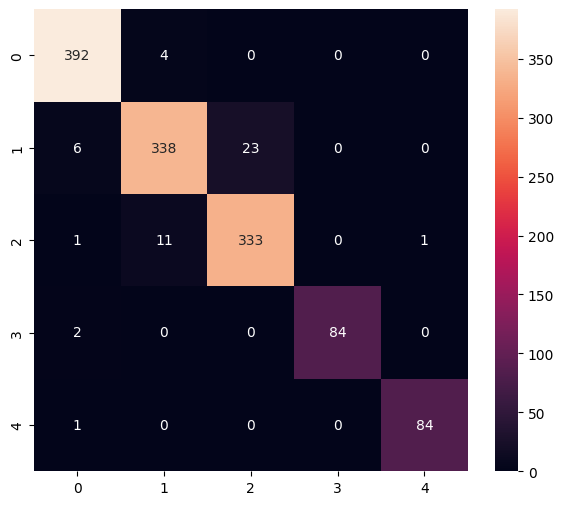

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       396
           1       0.96      0.92      0.94       367
           2       0.94      0.96      0.95       346
           3       1.00      0.98      0.99        86
           4       0.99      0.99      0.99        85

    accuracy                           0.96      1280
   macro avg       0.97      0.97      0.97      1280
weighted avg       0.96      0.96      0.96      1280



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [18]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/1h/drj472jn3w3gt2flqpkl14dm0000gn/T/tmp7nmkzeo6/assets


INFO:tensorflow:Assets written to: /var/folders/1h/drj472jn3w3gt2flqpkl14dm0000gn/T/tmp7nmkzeo6/assets
2023-11-21 17:51:36.001797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-21 17:51:36.001991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-11-21 17:51:36.002813: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/1h/drj472jn3w3gt2flqpkl14dm0000gn/T/tmp7nmkzeo6
2023-11-21 17:51:36.003323: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-11-21 17:51:36.003327: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/1h/drj472jn3w3gt2flqpkl14dm0000gn/T/tmp7nmkzeo6
2023-11-21 17:51:36.005757: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2023-11-21 17:51:36.006140: I tensorflow/cc/saved_model/load

6588

# Inference test

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [21]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 258 µs, sys: 931 µs, total: 1.19 ms
Wall time: 3.05 ms


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.0402657e-01 9.5124900e-02 8.4842532e-04 1.8837514e-07 2.8583361e-08]
0
